In [18]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading cleaned data

In [20]:
import pickle
file = open("data_risk2_dummy","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [21]:
from collections import Counter

Counter(y_train)

Counter({0: 109536, 1: 4293})

In [22]:
#rfecol = ['agegrp_3', 'agegrp_4', 'agegrp_5', 'agegrp_6', 'agegrp_7', 'agegrp_8','agegrp_9', 'agegrp_10', 'density_1', 
#          'density_2', 'race_2', 'race_4', 'nrelbc_1', 'nrelbc_2', 'lastmamm_0']
rfecol = ['menopaus_0', 'agegrp_2', 'agegrp_3', 'agegrp_4', 'agegrp_5',
       'agegrp_6', 'agegrp_7', 'agegrp_8', 'agegrp_9', 'agegrp_10',
       'density_1', 'density_4', 'race_2', 'race_3', 'race_4', 'race_5',
       'hispanic_0', 'hispanic_1', 'bmi_3', 'bmi_4', 'agefirst_1',
       'agefirst_2', 'nrelbc_0', 'nrelbc_2', 'lastmamm_1']

X_train=X_train[rfecol]
X_test=X_test[rfecol]

In [23]:
from imblearn.under_sampling import OneSidedSelection, RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline

#define pipeline
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
#under = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
#over = BorderlineSMOTE(random_state=0, n_jobs=-1)
over = ADASYN(random_state=0, n_jobs=-1)
steps=[('u', under), ('o',over)]
pipeline = Pipeline(steps=steps)
X_rs, y_rs = pipeline.fit_resample(X_train, y_train)

In [24]:
from collections import Counter

Counter(y_rs)

Counter({0: 8586, 1: 7991})

In [25]:
import pickle
file = open("data_rus_adasyn_risk2","wb")
pickle.dump(X_rs,file)
pickle.dump(y_rs,file)
pickle.dump(X_test,file)
pickle.dump(y_test,file)
file.close()

In [26]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi = TP / float(TP+FN)
    speci = TN / float(TN+FP)
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)

    print("Average:", (sensi+speci)/2)

    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### 2: Model Building

In [27]:
# Importing LogisticRegression and metrics from sklearn library
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [28]:
### Building model using regularization and cross validation

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Specify range of hyper-parameters to tune
hyper_params = {'C': [10, 1, 0.5, 0.1]}

# Specify model for logistic regression with option to treat class imbalance and perform grid search
logreg = LogisticRegression()

# GridSearchCV
model_cv = GridSearchCV(estimator = logreg,
                       param_grid = hyper_params,
                       scoring = "balanced_accuracy",
                       cv = folds,
                       verbose = 1,
                       return_train_score = True,
                       n_jobs=-1)

# Fit the model
model_cv.fit(X_rs,y_rs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 1, 0.5, 0.1]}, return_train_score=True,
             scoring='balanced_accuracy', verbose=1)

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

In [29]:
# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", model_cv.best_score_)
print("\n")
print(model_cv.best_estimator_)

best balanced accuracy 0.6286663668557402


LogisticRegression(C=0.5)


In [30]:
# It looks that C=0.1 and penalty='l1' are the best value

# Running Logistic Regression on Optimal hyperparameter value
logreg = LogisticRegression(C=0.10)

logreg.fit(X_rs,y_rs)

LogisticRegression(C=0.1)

# Coefficients
logreg.coef_

In [31]:
# List of cols with their coefficients
val=logreg.coef_.reshape(-1)
coef = pd.Series(val, index = X_rs.columns)
coef

menopaus_0    0.042518
agegrp_2      0.085343
agegrp_3      0.082204
agegrp_4      0.373461
agegrp_5      0.710733
agegrp_6      0.664765
agegrp_7      0.892979
agegrp_8      0.834791
agegrp_9      0.726324
agegrp_10     0.502145
density_1     0.016767
density_4     0.035338
race_2        0.023838
race_3        0.026147
race_4        0.028095
race_5        0.028889
hispanic_0    0.905983
hispanic_1    0.026931
bmi_3         0.035331
bmi_4         0.031884
agefirst_1    0.030733
agefirst_2    0.031564
nrelbc_0      0.370185
nrelbc_2      0.052975
lastmamm_1    0.038080
dtype: float64

In [32]:
# Running Logistic Regression with class_weight parameter to handle class imbalance
y_pred_train=logreg.predict(X_rs)
#y_pred_train=(logreg.predict_proba(X_train)[:,1] > 0.32).astype(bool)

Confusion Matrix ->
[[5388 3198]
 [2950 5041]]
Accuracy: 0.6291246908367014
Sensitivity: 0.6308346890251533
Specificity: 0.6275331935709294
Average: 0.6291839412980413
Precision 0.6118460978274063
MCC  0.2582060040236729
F1  0.6211953173136168
F2  0.6269432629405766
F3  0.6288829561615809
ROC-AUC : 0.66


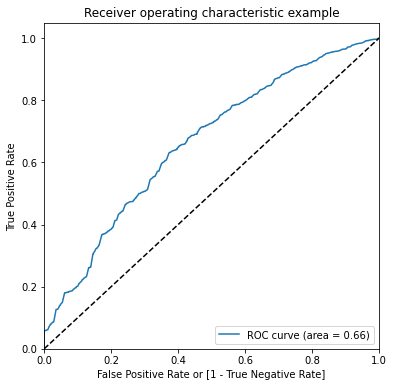

In [33]:
model_stats(X_rs, y_rs, y_pred_train, logreg)

In [34]:
y_pred_test=logreg.predict(X_test)
#y_pred_test=(logreg.predict_proba(X_test)[:,1] > 0.32).astype(bool)

Confusion Matrix ->
[[34881 23049]
 [  665   906]]
Accuracy: 0.6014520764356902
Sensitivity: 0.576702737110121
Specificity: 0.6021232522009322
Average: 0.5894129946555267
Precision 0.037820914214151534
MCC  0.05846245346782975
F1  0.0709864451931364
F2  0.14980654122160125
F3  0.23783272956371085
ROC-AUC : 0.61


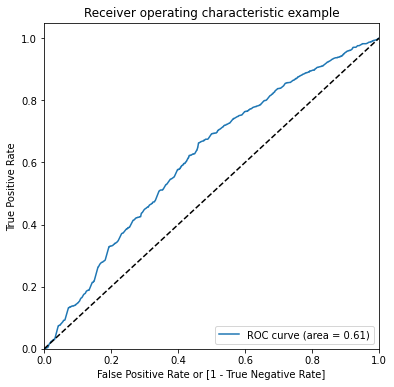

In [35]:
model_stats(X_test, y_test, y_pred_test, logreg)